## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [11]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [17]:
data = pd.read_csv('C:/Users/KarimovDO/Desktop/базы/ba.csv')

for i in range(len(data['Тяжесть'])):
    if data.loc[i, 'Уровень_VIP'] == ' ':
        data.loc[i, 'Уровень_VIP'] = np.NaN
data = data.dropna()

In [18]:
data = data.astype({'Уровень_VIP':'float', 'Уровень_SP':'float', 'Тяжесть':'object'})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 0 to 173
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Тяжесть           104 non-null    object 
 1   Уровень_VIP       104 non-null    float64
 2   Уровень_SP        104 non-null    float64
 3   SNP_rs896         104 non-null    object 
 4   SNP_rs2072100     104 non-null    object 
 5   SNP_rs3771829     104 non-null    object 
 6   SNP_rs3823082     104 non-null    object 
 7   VAR_mc            104 non-null    int64  
 8   aVNN_mc           104 non-null    int64  
 9   SDNN_mc           104 non-null    int64  
 10  pNN50             104 non-null    int64  
 11  rMSSD             104 non-null    int64  
 12  SDNNidx_mc        104 non-null    int64  
 13  SDANN_mc          104 non-null    int64  
 14  VLF               104 non-null    int64  
 15  LF_Симпатика      104 non-null    int64  
 16  HF_Парасимпатика  104 non-null    int64  
 1

In [19]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=boot_it/20
               ,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {#"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value,
            "p_value2": round(p_value,5)
            }

In [20]:
data = data.rename(columns = {'Тяжесть':'severity'})

<AxesSubplot:xlabel='severity', ylabel='Уровень_VIP'>

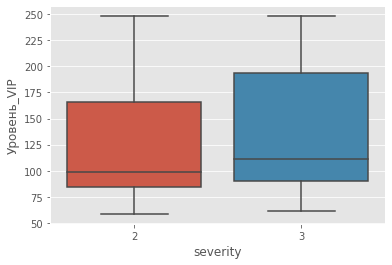

In [21]:
sns.boxplot(x="severity", y="Уровень_VIP", data=data)

In [23]:
ttest_ind(data[data.severity == 2]['Уровень_VIP'], 
          data[data.severity == 3]['Уровень_VIP'])

Ttest_indResult(statistic=-1.1691385926207296, pvalue=0.24507276902435632)

In [24]:
mannwhitneyu(data[data.severity == 2]['Уровень_VIP'], 
             data[data.severity == 3]['Уровень_VIP'])

MannwhitneyuResult(statistic=1166.0, pvalue=0.24688607618006675)

  0%|          | 0/10000 [00:00<?, ?it/s]

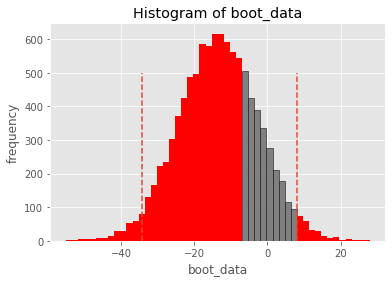

{'quants':                0
 0.025 -34.344473
 0.975   7.972018,
 'p_value': 0.2183283209894249,
 'p_value2': 0.21833}

In [60]:
booted_data = get_bootstrap(
    data[data.severity == 2]['Уровень_VIP'], # числовые значения первой выборки
    data[data.severity == 3]['Уровень_VIP'],
    boot_it = 10000
)
booted_data


<AxesSubplot:xlabel='severity', ylabel='Уровень_SP'>

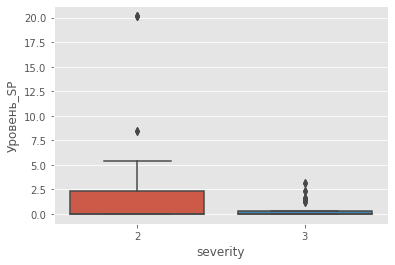

In [26]:
sns.boxplot(x="severity", y="Уровень_SP", data=data)

In [27]:
ttest_ind(data[data.severity == 2]['Уровень_SP'], 
          data[data.severity == 3]['Уровень_SP'])

Ttest_indResult(statistic=2.5067349991668166, pvalue=0.01376452226457987)

In [28]:
mannwhitneyu(data[data.severity == 2]['Уровень_SP'], 
             data[data.severity == 3]['Уровень_SP'])

MannwhitneyuResult(statistic=1560.0, pvalue=0.08548882161786886)

  0%|          | 0/10000 [00:00<?, ?it/s]

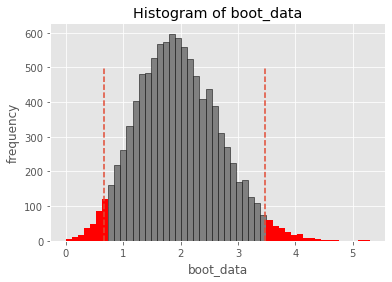

{'quants':               0
 0.025  0.671388
 0.975  3.462147,
 'p_value': 0.006563191322677529,
 'p_value2': 0.00656}

In [29]:
booted_data = get_bootstrap(
    data[data.severity == 2]['Уровень_SP'], # числовые значения первой выборки
    data[data.severity == 3]['Уровень_SP'],
    boot_it = 10000)
booted_data


In [30]:
data[data.severity == 2]['Уровень_VIP'].mean()

122.50142857142855

In [31]:

data[data.severity == 3]['Уровень_VIP'].mean()

135.885